In [49]:
import numpy as np
import pandas as pd

num_of_stocks = 2000  # the number of stocks given in our problem

#DataFrame is created with the csv file
df = pd.read_csv('54_hfc_20170614_comp.csv', names=range(num_of_stocks),dtype='float64')

In [50]:
#Panda's DataFrame is easier to handle, 
#but a matrix made in Numpy is much faster to call its values
corr_matrix = np.corrcoef(df.T)
corr_matrix = np.array(corr_matrix, dtype='float64')
corr_matrix.shape

(2000, 2000)

In [51]:
corr_matrix

array([[ 1.        ,  0.32812763,  0.25039209, ...,  0.07767997,
         0.15313015,  0.11625553],
       [ 0.32812763,  1.        ,  0.30692909, ...,  0.0970023 ,
         0.16112116,  0.12983041],
       [ 0.25039209,  0.30692909,  1.        , ...,  0.11895504,
         0.25685403,  0.18558064],
       ..., 
       [ 0.07767997,  0.0970023 ,  0.11895504, ...,  1.        ,
         0.20246797,  0.27148316],
       [ 0.15313015,  0.16112116,  0.25685403, ...,  0.20246797,
         1.        ,  0.33354819],
       [ 0.11625553,  0.12983041,  0.18558064, ...,  0.27148316,
         0.33354819,  1.        ]])

In [4]:
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

In [28]:
print(sorted(eigenvalues, reverse = True)[:10])

[598.90365445463203, 50.16562256064222, 32.38198789504743, 27.681201401951505, 21.008021351321101, 18.052430240549906, 12.776115696399369, 12.233998390438916, 11.025018432631072, 10.238383901632831]


In [29]:
print(np.flipud(np.argsort(eigenvalues))[:10])

eigenvalues[0]


[0 1 2 3 4 5 6 7 8 9]


598.90365445463203

In [27]:
eigenvectors[0]

array([-0.02192866, -0.00549809, -0.0104368 , ...,  0.00914693,
        0.00500807,  0.00495962])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


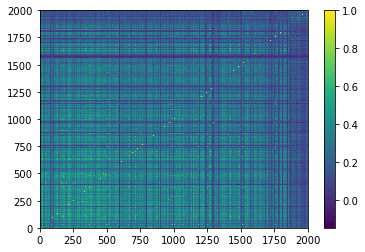

In [53]:
%time
import matplotlib.pyplot as plt
%matplotlib inline
x = np.arange(2000)
y = np.arange(2000)
x, y = np.meshgrid(x, y)

#convert intensity (list of lists) to a numpy array for plotting
intensity = corr_matrix.copy()

#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale
plt.show()

In [54]:
#defining the functions for calculating TICS, CARS and the value to be minimized

def Calc_IC(sub_group_of_stocks):
    return np.corrcoef(df.loc[:,sub_group_of_stocks].T).sum()

def Calc_TICS(list_of_stocks):
    TICS = {}
    for i in range(len(list_of_stocks)):
        TICS[i]=(Calc_IC(list_of_stocks[i])) #here the number i is the group number
    return sum(TICS.values())

def Calc_CARS(list_of_stocks): 
    CARS_dict = {}
    CARS_dict.update({'AR{}'.format(i): df[list_of_stocks[i]].mean(axis=1) for i in range(10)})

    temp_list = []
    for i in range(10):
        temp_list.append(CARS_dict['AR{}'.format(i)])
    
    CARS = np.corrcoef(temp_list).sum()
    return CARS

def objective_function(list_of_stocks):
    return Calc_CARS(list_of_stocks)/Calc_TICS(list_of_stocks)



In [55]:
def find_stock_group(list_of_stocks, stock_number):
    for i in range(10):
        if stock_number in list_of_stocks[i]:
            return (stock_number, i)  #i is the group number 
        
def find_stock_location(list_of_stocks, stock_number):
    for i in range(10):
        if stock_number in list_of_stocks[i]:
            for j in range(200):
                if stock_number == list_of_stocks[i,j]:
                    return (i,j)  #i is the group number and j is the location within the group


In [56]:
#this part below is the list of functions used when the each group is formed

#find_the_next_min function is used to find the next element within a group when the group is formed
def find_the_next_min(group, reference_set):
    index, min_ = 0, 9999  #initialization of the variables
    for i in reference_set:
        if i not in group:
            intra_value = sum([corr_matrix[element,i] for element in group])
            inter_value = (corr_matrix[i].sum() - 2*intra_value - 1)
            value = abs(inter_value/intra_value)
            if value < min_:
                index, min_ = i, value
    return (index, min_)

#using the find_the_next_min function, group elements are added until its number reaches 200
def add_element_to_group(group, reference_set):
    while len(group) < 200:
        group.append(find_the_next_min(group, reference_set)[0])

#when one group is formed, the first element in the next group is found using find_the_next_max function
def find_the_next_max(reference_set):
    group_list = list(set(range(2000)) - reference_set)
    index, max_ = 0, -9999
    for i in reference_set:
        intra_value = sum([corr_matrix[element,i] for element in group_list])
        inter_value = (corr_matrix[i].sum() - 2*intra_value - 1)
        value = abs(inter_value/intra_value)
        if value > max_:
            index, max_ = i, value
    return (index, max_)

In [57]:
def find_partitions(reference_set):
    for i in range(10):
        add_element_to_group(eval('group_{}'.format(i)), reference_set)
        reference_set = reference_set - set(eval('group_{}'.format(i)))
        #print('group_{} has been made'.format(i))
        i += 1
        if i != 10:
            eval('group_{}'.format(i)).append(find_the_next_max(reference_set)[0])

    

    
def find_the_initial_parameter(num_of_repetition):
    
    initial_min = 0.000562
    current_min = initial_min
    
    
    for k in range(num_of_repetition):
        
        print(k, '-repetition has started')
        #temp list of stocks before partitioning
        list_of_stocks = np.arange(2000).reshape(10,200)
        reference_set = set(list(range(1,2000)))
        initial_stock_picked = np.random.choice(list(reference_set))

        for i in range(10):  
            temp = ''           
            temp = 'group_'+str(i)+'=[]'
            exec(temp)

        group_0.append(initial_stock_picked)    

        for i in range(10):
            add_element_to_group(eval('group_{}'.format(i)), reference_set)
            reference_set = reference_set - set(eval('group_{}'.format(i)))
            i += 1
            if i != 10:
                eval('group_{}'.format(i)).append(find_the_next_max(reference_set)[0])    

        for i in range(10):
            list_of_stocks[i] = eval('group_{}'.format(i))

        result = objective_function(list_of_stocks)
        if  result < current_min:
            current_min = result
            print((initial_stock_picked, result))
            initial_param_result.append((initial_stock_picked, result))
            

  

In [62]:
find_partitions(reference_set)

NameError: name 'reference_set' is not defined

In [ ]:
temp_list = np.arange(2000)

In [45]:
#now I need the functions for optimization after the whole 10 groups are formed
def intra_group_sum_corr_matrix(stock_list, group_number):
    return np.sum(corr_matrix[stock_list[group_number], :][:, stock_list[group_number]])

def inter_group_sum_corr_matrix(stock_list, group_number):
    return np.sum(corr_matrix[stock_list[group_number], :])-intra_group_sum_corr_matrix(stock_list, group_number)

initial_sum_intra = []
initial_sum_inter = []

def initialize_sum(list_of_stocks):
    stock_list = list_of_stocks.copy()
    for i in range(10):
        initial_sum_intra.append(intra_group_sum_corr_matrix(stock_list, i))
        initial_sum_inter.append(inter_group_sum_corr_matrix(stock_list, i))

initialize_sum(list_of_stocks)
initial_score = np.array(initial_sum_inter)/np.array(initial_sum_intra)
#we want the small inter_sum and large intra_sum, meaning that the smaller value of the equation 
#above is preferred

initial_score


IndexError: index 224 is out of bounds for axis 1 with size 200

In [46]:
current_score

NameError: name 'current_score' is not defined

In [47]:
#current_score = initial_score.copy()

stock_location_dict = {}
for i in range(num_of_stocks):
    stock_location_dict[i] = find_stock_location(list_of_stocks, i)
    #for exmaple, stock_location_dict[0] = (1,3) means the location is group_1 and 3 within group_1 
    
#in this method, stock_location_dict needs to be updated whenever locations changed
def fast_stock_location(stock_number):
    return stock_location_dict[stock_number]

#swap function will be used when exchanging a pair of stocks between two different groups
#it exchanges the location of stock1 with that of stock2 in list_of_stocks
def swap(list_of_stocks,stock1,stock2):
    stock_list = list_of_stocks.copy()
    loc_of_stock1 = fast_stock_location(stock1)
    loc_of_stock2 = fast_stock_location(stock2)
    stock_list[loc_of_stock1], stock_list[loc_of_stock2] = stock_list[loc_of_stock2], stock_list[loc_of_stock1]
    return stock_list
    
    #list_of_stocks = swap(list_of_stocks, stock1, stock2)
    #stock_location_dict.update({stock1:loc_of_stock2, stock2: loc_of_stock1})

def swap_between_groups(list_of_stocks, group1, group2):
    min_ = 9999  #initialization of the variables
    
    current_score_for_two = current_score[group1]+current_score[group2] 
    
    for stock1 in list_of_stocks[group1]:
        for stock2 in list_of_stocks[group2]:
        
            stock_list = swap(list_of_stocks,stock1,stock2)
        
            intra_value_1 = intra_group_sum_corr_matrix(stock_list, group1)
            inter_value_1 = intra_group_sum_corr_matrix(stock_list, group1)
            score_1 = inter_value_1/intra_value_1

            intra_value_2 = intra_group_sum_corr_matrix(stock_list, group2)
            inter_value_2 = intra_group_sum_corr_matrix(stock_list, group2)
            score_2 = inter_value_2/intra_value_2

            if score_1 + score_2 < current_score_for_two:
                list_of_stocks = stock_list.copy()
                loc_of_stock1 = fast_stock_location(stock1)
                loc_of_stock2 = fast_stock_location(stock2)
                stock_location_dict.update({stock1:loc_of_stock2, stock2: loc_of_stock1})
                current_score[group1] = score_1
                current_score[group2] = score_2
                
def optimize_corr_matrix(list_of_stocks):
    for i in range(10):
        for j in range(10):
            if i == j:
                continue
            print('optimizing group_{} with group_{}'.format(i, j),'has started its loop')
            swap_between_groups(list_of_stocks, i, j)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [38]:
optimize_corr_matrix(list_of_stocks)

optimizing group_0 with group_1 has started its loop
optimizing group_0 with group_2 has started its loop
optimizing group_0 with group_3 has started its loop
optimizing group_0 with group_4 has started its loop
optimizing group_0 with group_5 has started its loop
optimizing group_0 with group_6 has started its loop
optimizing group_0 with group_7 has started its loop
optimizing group_0 with group_8 has started its loop
optimizing group_0 with group_9 has started its loop
optimizing group_1 with group_0 has started its loop
optimizing group_1 with group_2 has started its loop
optimizing group_1 with group_3 has started its loop
optimizing group_1 with group_4 has started its loop
optimizing group_1 with group_5 has started its loop
optimizing group_1 with group_6 has started its loop
optimizing group_1 with group_7 has started its loop
optimizing group_1 with group_8 has started its loop
optimizing group_1 with group_9 has started its loop
optimizing group_2 with group_0 has started it

In [63]:
objective_function(list_of_stocks)

KeyError: '[ (224, 599, 634, 707, 732, 789, 792, 832, 839, 868, 923, 947, 969, 973, 996, 1075, 1118, 1122, 1146, 1165, 1231, 1298, 1303, 1344, 1361, 1363, 1387, 1399, 1412, 1445, 1447, 1452, 1454, 1476, 1482, 1489, 1491, 1493, 1497, 1511, 1521, 1524, 1526, 1550, 1570, 1575, 1577, 1581, 1582, 1586, 1599, 1602, 1624, 1650, 1657, 1660, 1662, 1682, 1697, 1702, 1708, 1710, 1713, 1729, 1734, 1735, 1740, 1743, 1744, 1749, 1761, 1764, 1785, 1791, 1801, 1802, 1805, 1809, 1813, 1815, 1817, 1822, 1824, 1826, 1835, 1837, 1850, 1852, 1853, 1854, 1862, 1867, 1868, 1870, 1872, 1875, 1877, 1880, 1883, 1885, 1889, 1890, 1891, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1903, 1907, 1909, 1910, 1911, 1912, 1914, 1915, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999)\n (12, 14, 17, 20, 27, 31, 42, 55, 64, 70, 76, 78, 82, 88, 90, 95, 102, 104, 105, 108, 117, 124, 174, 181, 184, 185, 186, 191, 192, 194, 198, 200, 204, 210, 221, 244, 269, 279, 281, 302, 321, 337, 345, 384, 404, 418, 424, 455, 473, 476, 478, 486, 494, 497, 498, 518, 522, 527, 536, 537, 562, 563, 568, 569, 580, 581, 587, 591, 596, 610, 615, 618, 622, 652, 658, 669, 673, 676, 689, 693, 706, 712, 718, 729, 730, 735, 736, 740, 747, 762, 764, 765, 769, 772, 781, 807, 812, 824, 827, 828, 843, 844, 870, 875, 878, 882, 892, 893, 918, 921, 924, 939, 941, 943, 951, 976, 978, 980, 1026, 1032, 1045, 1065, 1072, 1087, 1088, 1095, 1106, 1124, 1125, 1131, 1132, 1133, 1136, 1141, 1152, 1155, 1167, 1169, 1170, 1183, 1185, 1206, 1217, 1223, 1229, 1236, 1241, 1244, 1246, 1247, 1253, 1271, 1273, 1278, 1288, 1310, 1319, 1323, 1328, 1333, 1426, 1427, 1434, 1435, 1460, 1475, 1480, 1487, 1494, 1500, 1516, 1537, 1539, 1546, 1559, 1571, 1594, 1596, 1606, 1607, 1617, 1634, 1637, 1647, 1651, 1654, 1676, 1677, 1680, 1681, 1686, 1703, 1725, 1757, 1783, 1789, 1796, 1799, 1839, 1884)\n (3, 8, 13, 34, 35, 46, 59, 68, 91, 97, 110, 113, 128, 130, 170, 173, 180, 187, 240, 253, 255, 256, 258, 341, 369, 373, 375, 377, 378, 386, 392, 394, 399, 401, 410, 412, 444, 446, 449, 485, 502, 507, 509, 526, 528, 530, 544, 546, 557, 574, 575, 579, 584, 590, 598, 600, 604, 611, 624, 628, 643, 648, 660, 666, 668, 684, 719, 744, 751, 756, 767, 777, 786, 800, 825, 835, 846, 851, 858, 863, 871, 874, 894, 901, 934, 936, 955, 972, 987, 994, 997, 1003, 1009, 1039, 1042, 1043, 1056, 1057, 1069, 1092, 1096, 1100, 1111, 1130, 1138, 1145, 1147, 1160, 1161, 1164, 1184, 1186, 1188, 1204, 1207, 1235, 1256, 1272, 1276, 1281, 1284, 1287, 1291, 1297, 1300, 1325, 1352, 1368, 1390, 1391, 1394, 1397, 1406, 1432, 1436, 1456, 1463, 1477, 1481, 1490, 1496, 1503, 1508, 1517, 1532, 1533, 1540, 1541, 1545, 1549, 1552, 1553, 1555, 1556, 1558, 1564, 1568, 1572, 1573, 1583, 1585, 1587, 1589, 1597, 1611, 1636, 1639, 1645, 1658, 1665, 1675, 1692, 1700, 1705, 1714, 1718, 1736, 1746, 1753, 1756, 1760, 1763, 1767, 1771, 1772, 1773, 1775, 1777, 1797, 1798, 1833, 1844, 1847, 1855, 1858, 1863, 1864, 1887, 1888, 1931)\n (2, 18, 25, 26, 28, 56, 61, 62, 84, 98, 107, 122, 216, 243, 266, 272, 275, 278, 295, 318, 335, 342, 359, 371, 402, 409, 413, 447, 519, 554, 582, 585, 601, 609, 616, 621, 623, 625, 626, 627, 635, 638, 639, 649, 650, 670, 675, 677, 678, 698, 708, 711, 717, 720, 725, 726, 727, 728, 737, 742, 743, 754, 757, 760, 761, 766, 774, 776, 782, 788, 791, 796, 809, 834, 867, 880, 888, 890, 904, 908, 917, 919, 937, 953, 956, 960, 964, 966, 970, 977, 981, 983, 985, 1001, 1002, 1013, 1018, 1020, 1022, 1028, 1029, 1031, 1034, 1044, 1060, 1062, 1078, 1085, 1089, 1094, 1101, 1129, 1142, 1171, 1172, 1174, 1193, 1196, 1202, 1214, 1232, 1240, 1248, 1259, 1266, 1282, 1293, 1299, 1307, 1309, 1311, 1312, 1321, 1327, 1332, 1337, 1350, 1356, 1371, 1376, 1384, 1385, 1388, 1389, 1392, 1400, 1404, 1405, 1407, 1411, 1419, 1425, 1429, 1430, 1431, 1433, 1442, 1453, 1462, 1472, 1479, 1498, 1501, 1502, 1505, 1506, 1513, 1514, 1520, 1544, 1548, 1574, 1578, 1584, 1588, 1593, 1598, 1615, 1616, 1653, 1688, 1709, 1711, 1722, 1724, 1728, 1733, 1739, 1742, 1752, 1768, 1788, 1793, 1794, 1795, 1804, 1806, 1831, 1902, 1906)\n (9, 10, 32, 47, 54, 65, 72, 73, 75, 81, 83, 85, 92, 94, 96, 103, 109, 112, 114, 115, 121, 123, 133, 138, 143, 151, 153, 155, 159, 161, 162, 164, 166, 167, 168, 169, 189, 193, 196, 203, 207, 214, 219, 230, 232, 245, 246, 248, 254, 259, 260, 263, 268, 270, 273, 293, 294, 296, 305, 307, 308, 311, 315, 322, 323, 333, 338, 343, 349, 352, 353, 354, 363, 364, 374, 379, 380, 381, 385, 391, 395, 396, 403, 407, 411, 414, 415, 416, 425, 426, 430, 432, 434, 453, 454, 456, 459, 460, 461, 464, 467, 468, 475, 479, 480, 482, 490, 503, 506, 508, 512, 515, 523, 538, 547, 549, 550, 551, 561, 565, 566, 570, 576, 577, 578, 607, 631, 633, 679, 695, 701, 702, 704, 715, 749, 753, 758, 808, 810, 814, 822, 829, 831, 845, 861, 887, 897, 899, 902, 906, 910, 913, 949, 961, 1000, 1008, 1010, 1038, 1040, 1049, 1073, 1086, 1116, 1139, 1156, 1175, 1191, 1192, 1195, 1210, 1222, 1242, 1305, 1318, 1348, 1365, 1366, 1374, 1381, 1401, 1417, 1443, 1465, 1466, 1473, 1483, 1484, 1492, 1512, 1527, 1529, 1563, 1678, 1689, 1741, 1808, 1849, 1866, 1876, 1879)\n (30, 40, 57, 58, 71, 77, 87, 93, 119, 132, 141, 145, 178, 188, 211, 213, 217, 225, 228, 231, 239, 242, 247, 251, 257, 264, 280, 290, 291, 299, 313, 314, 316, 324, 326, 328, 329, 332, 339, 360, 366, 387, 397, 398, 419, 420, 427, 435, 438, 445, 448, 451, 465, 483, 492, 513, 514, 521, 529, 531, 545, 556, 567, 571, 573, 583, 588, 589, 595, 605, 619, 630, 636, 642, 644, 645, 656, 659, 661, 665, 680, 696, 722, 731, 741, 746, 759, 763, 784, 790, 793, 797, 801, 802, 806, 826, 830, 837, 840, 848, 860, 872, 873, 876, 877, 879, 881, 883, 884, 886, 889, 891, 909, 926, 952, 958, 965, 986, 989, 999, 1014, 1024, 1036, 1048, 1054, 1059, 1066, 1076, 1081, 1082, 1084, 1097, 1109, 1112, 1117, 1123, 1135, 1154, 1157, 1162, 1194, 1201, 1219, 1220, 1234, 1237, 1243, 1254, 1255, 1274, 1285, 1301, 1316, 1322, 1326, 1334, 1349, 1353, 1360, 1362, 1378, 1410, 1438, 1441, 1451, 1455, 1499, 1518, 1543, 1551, 1560, 1562, 1580, 1591, 1608, 1621, 1635, 1648, 1659, 1661, 1667, 1668, 1671, 1691, 1720, 1723, 1748, 1755, 1779, 1780, 1782, 1800, 1811, 1816, 1834, 1845, 1846, 1856, 1869, 1882)\n (7, 22, 23, 41, 44, 49, 50, 101, 106, 140, 142, 150, 195, 197, 223, 271, 286, 303, 304, 317, 325, 334, 350, 362, 370, 372, 400, 422, 423, 463, 477, 484, 488, 510, 511, 532, 555, 559, 564, 593, 594, 606, 613, 617, 629, 637, 646, 662, 667, 672, 683, 686, 688, 703, 709, 713, 738, 745, 750, 768, 771, 813, 816, 817, 836, 838, 853, 855, 862, 903, 905, 914, 915, 916, 925, 929, 930, 942, 944, 963, 975, 979, 984, 995, 1006, 1011, 1015, 1017, 1019, 1041, 1064, 1070, 1090, 1110, 1114, 1120, 1126, 1128, 1134, 1137, 1140, 1143, 1144, 1149, 1150, 1158, 1179, 1199, 1209, 1225, 1227, 1245, 1264, 1267, 1277, 1279, 1280, 1283, 1286, 1290, 1294, 1302, 1304, 1306, 1317, 1320, 1329, 1343, 1346, 1347, 1357, 1372, 1375, 1379, 1380, 1382, 1386, 1396, 1398, 1408, 1409, 1421, 1423, 1424, 1444, 1446, 1449, 1461, 1464, 1467, 1471, 1485, 1486, 1509, 1515, 1542, 1561, 1565, 1567, 1579, 1600, 1601, 1605, 1609, 1610, 1622, 1623, 1638, 1656, 1673, 1679, 1696, 1704, 1712, 1719, 1727, 1758, 1765, 1766, 1770, 1784, 1786, 1792, 1818, 1820, 1829, 1836, 1840, 1842, 1848, 1857, 1865, 1873, 1881, 1892, 1901, 1905, 1908, 1916, 1966)\n (1, 4, 11, 15, 16, 21, 29, 38, 39, 60, 67, 74, 79, 99, 116, 118, 120, 125, 134, 135, 147, 154, 163, 165, 177, 182, 190, 205, 208, 220, 222, 227, 234, 238, 249, 250, 274, 276, 277, 282, 297, 298, 300, 310, 312, 344, 346, 347, 351, 356, 358, 361, 367, 382, 428, 431, 433, 439, 441, 443, 457, 462, 466, 470, 491, 504, 517, 535, 541, 548, 603, 614, 651, 654, 663, 681, 687, 690, 691, 699, 700, 710, 716, 721, 748, 775, 778, 787, 794, 798, 799, 803, 804, 805, 811, 819, 821, 823, 833, 842, 849, 850, 859, 869, 895, 896, 900, 907, 912, 920, 933, 945, 946, 957, 967, 968, 982, 988, 990, 991, 998, 1007, 1016, 1025, 1030, 1033, 1052, 1058, 1067, 1068, 1077, 1079, 1093, 1098, 1099, 1102, 1105, 1107, 1108, 1127, 1153, 1159, 1177, 1178, 1181, 1189, 1198, 1208, 1211, 1216, 1226, 1230, 1257, 1261, 1265, 1292, 1308, 1313, 1315, 1330, 1331, 1342, 1369, 1383, 1402, 1416, 1457, 1458, 1459, 1474, 1478, 1488, 1504, 1530, 1531, 1547, 1557, 1569, 1595, 1612, 1613, 1618, 1628, 1631, 1632, 1646, 1655, 1663, 1690, 1698, 1699, 1706, 1717, 1721, 1726, 1731, 1737, 1832, 1874, 1886)\n (6, 36, 37, 51, 52, 63, 66, 86, 89, 126, 131, 136, 146, 148, 149, 156, 157, 158, 160, 172, 176, 199, 201, 202, 206, 212, 215, 233, 235, 241, 252, 262, 265, 267, 284, 285, 288, 289, 292, 301, 306, 309, 319, 320, 327, 330, 331, 348, 357, 383, 388, 389, 390, 406, 417, 421, 429, 436, 440, 452, 458, 469, 471, 481, 489, 493, 501, 516, 520, 524, 525, 533, 534, 540, 542, 543, 553, 586, 592, 608, 620, 641, 653, 671, 674, 682, 705, 714, 723, 733, 739, 779, 783, 795, 847, 852, 854, 864, 865, 885, 922, 928, 932, 935, 959, 974, 993, 1012, 1051, 1053, 1061, 1080, 1083, 1104, 1113, 1115, 1151, 1163, 1173, 1187, 1190, 1213, 1215, 1228, 1238, 1249, 1251, 1258, 1260, 1263, 1269, 1270, 1275, 1295, 1314, 1324, 1336, 1338, 1339, 1345, 1351, 1354, 1364, 1367, 1370, 1377, 1403, 1420, 1422, 1428, 1439, 1440, 1450, 1468, 1495, 1510, 1522, 1534, 1536, 1538, 1554, 1566, 1592, 1603, 1614, 1619, 1625, 1627, 1630, 1633, 1652, 1672, 1687, 1694, 1695, 1707, 1716, 1730, 1732, 1745, 1750, 1759, 1774, 1778, 1781, 1790, 1803, 1807, 1810, 1812, 1825, 1827, 1841, 1851, 1859, 1860, 1861, 1878, 1904, 1913)\n (0, 5, 19, 24, 33, 43, 45, 48, 53, 69, 80, 100, 111, 127, 129, 137, 139, 144, 152, 171, 175, 179, 183, 209, 218, 226, 229, 236, 237, 261, 283, 287, 336, 340, 355, 365, 368, 376, 393, 405, 408, 437, 442, 450, 472, 474, 487, 495, 496, 499, 500, 505, 539, 552, 558, 560, 572, 597, 602, 612, 632, 640, 647, 655, 657, 664, 685, 692, 694, 697, 724, 734, 752, 755, 770, 773, 780, 785, 815, 818, 820, 841, 856, 857, 866, 898, 911, 927, 931, 938, 940, 948, 950, 954, 962, 971, 992, 1004, 1005, 1021, 1023, 1027, 1035, 1037, 1046, 1047, 1050, 1055, 1063, 1071, 1074, 1091, 1103, 1119, 1121, 1148, 1166, 1168, 1176, 1180, 1182, 1197, 1200, 1203, 1205, 1212, 1218, 1221, 1224, 1233, 1239, 1250, 1252, 1262, 1268, 1289, 1296, 1335, 1340, 1341, 1355, 1358, 1359, 1373, 1393, 1395, 1413, 1414, 1415, 1418, 1437, 1448, 1469, 1470, 1507, 1519, 1523, 1525, 1528, 1535, 1576, 1590, 1604, 1620, 1626, 1629, 1640, 1641, 1642, 1643, 1644, 1649, 1664, 1666, 1669, 1670, 1674, 1683, 1684, 1685, 1693, 1701, 1715, 1738, 1747, 1751, 1754, 1762, 1769, 1776, 1787, 1814, 1819, 1821, 1823, 1828, 1830, 1838, 1843, 1871)] not in index'

In [10]:
initial_list_of_stocks = list_of_stocks.copy()
current_min = objective_function(initial_list_of_stocks)

In [11]:
objective_function(initial_list_of_stocks)
#list_of_stocks = initial_list_of_stocks.copy()

0.00056183968503703162

In [40]:
list_of_stocks

array([[1890, 1729, 1862, ..., 1926, 1196, 1361],
       [ 735, 1579,  827, ...,  893,   64, 1757],
       [   3, 1895, 1911, ...,   59, 1705, 1864],
       ..., 
       [1052, 1189, 1226, ...,  716,   45,  139],
       [1592, 1825, 1732, ...,  540, 1339, 1238],
       [1415, 1166,  971, ...,  500,   48,    0]])

In [51]:
list(stock_location_dict[0])
alternative_list

0

In [43]:
alternative_list = np.arange(2000).reshape((10,200))
for i in range(2000):
    alternative_list[list(stock_location_dict[i])[0],list(stock_location_dict[i])[1]] = i
    
alternative_list

KeyError: 0

In [53]:
objective_function(alternative_list)

0.00087510850628080231

In [48]:
stock_location_dict = {}
for i in range(num_of_stocks):
    stock_location_dict[i] = find_stock_location(list_of_stocks, i)

#in this method, stock_location_dict needs to be updated whenever locations changed
def fast_stock_location(stock_number):
    return stock_location_dict[stock_number]

#swap function will be used when exchanging a pair of stocks between two different groups
def swap_without_return(list_of_stocks,stock1,stock2):
    loc_of_stock1 = fast_stock_location(stock1)
    loc_of_stock2 = fast_stock_location(stock2)
    list_of_stocks[loc_of_stock1], list_of_stocks[loc_of_stock2] = list_of_stocks[loc_of_stock2], list_of_stocks[loc_of_stock1]
    stock_location_dict.update({stock1:loc_of_stock2, stock2: loc_of_stock1})

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [13]:
reference_total = set(np.arange(2000))
def find_the_min(list_of_stocks, group_list, stock_loc): #stock_loc is the location index within the group
    stock = group_list[stock_loc]
    reference = reference_total - set(group_list) | {stock}
    result = find_the_next_min(np.delete(group_list,stock_loc), reference)
    global current_min
    if result[0] != stock: 
        swap(list_of_stocks, stock, result[0])
        temp_ = objective_function(list_of_stocks)
        if  temp_ < current_min:
            current_min = temp_
            print('Swapped, now the min value is', current_min)
        else: 
            swap(list_of_stocks, stock, result[0])
            

In [14]:
current_min

0.00056183968503703162

In [15]:
def optimize_the_first_part(list_of_stocks):
    for i in range(50): #here i is the column number (first i elements in each group)
        print(i, 'has started')
        for j in range(10): #j is the row number (group number)
            find_the_min(list_of_stocks, list_of_stocks[j],i)

def random_optimize(list_of_stocks, num_of_iteration):
    for i in range(num_of_iteration):
        find_the_min(list_of_stocks, list_of_stocks[np.random.randint(10)],np.random.randint(200))

def optimize_the_second_part(list_of_stocks):
    for i in range(150,200): #here i is the column number (first i elements in each group)
        print(i, 'has started')
        for j in range(10): #j is the row number (group number)
            find_the_min(list_of_stocks, list_of_stocks[j],i)
            
def optimize_the_whole_part(list_of_stocks, num_of_iteration):
    for number in range(num_of_iteration):
        optimize_the_first_part(list_of_stocks)
        optimize_the_second_part(list_of_stocks)

In [16]:
optimize_the_whole_part(list_of_stocks,1)

0 has started
Swapped, now the min value is 0.000561406585407
1 has started
Swapped, now the min value is 0.00056136874099
2 has started
3 has started
Swapped, now the min value is 0.00056129784413
4 has started
5 has started
Swapped, now the min value is 0.000561283836741
6 has started
7 has started
8 has started
9 has started
10 has started
11 has started
Swapped, now the min value is 0.000561264831862
12 has started
13 has started
14 has started
15 has started
16 has started
17 has started
18 has started
19 has started
20 has started
Swapped, now the min value is 0.000561249947149
21 has started
22 has started
23 has started
Swapped, now the min value is 0.000561205596527
24 has started
25 has started
26 has started
27 has started
28 has started
29 has started
Swapped, now the min value is 0.000561108989494
30 has started
31 has started
32 has started
33 has started
34 has started
35 has started
36 has started
37 has started
38 has started
Swapped, now the min value is 0.00056105308

In [17]:
answer_list = list_of_stocks.copy()

In [18]:
current_min

0.00056049483503055894

In [55]:
a = set()
for i in range(10):
    a.update(set(list_of_stocks[i]))
len(a) #this shows that there is no dupulicated element

2000

In [37]:
objective_function(answer_list)

NameError: name 'answer_list' is not defined

In [48]:
def minimize(list_of_stocks, fixed_row = 0,fixed_col = 199):
    result = {}
    global current_min
    
    for i in range(0,10):
        if i != fixed_row: #here being in the same row means being in the same group - so avoids the case
            print(i, 'started')
            for j in range(0,199):
                temp_list = list_of_stocks.copy()
                swap(temp_list,temp_list[fixed_row,j],temp_list[i,fixed_col])
                temp_ = objective_function(temp_list)
                if  temp_ < current_min:
                    current_min = temp_
                    print('found',(list_of_stocks[fixed_row,j],list_of_stocks[i,fixed_col]), temp_)
                    result[(list_of_stocks[fixed_row,j],list_of_stocks[i,fixed_col])] = temp_ 
    return result
swap(list_of_stocks, stock, result[0])
        temp_ = objective_function(list_of_stocks)
        if  temp_ < current_min:
            current_min = temp_
            print('Swapped, now the min value is', current_min)
        else: 
            swap(list_of_stocks, stock, result[0])
#starting fixed_row = 0, fixed_col = 199
#in the swapping process, 
#I chose the very last elements in each group first as they contribute to the TICS the least

In [84]:
objective_function(list_of_stocks)

0.0005616102499263545

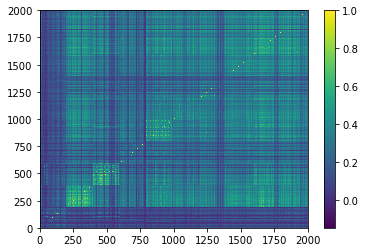

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
x = np.arange(2000)
y = np.arange(2000)
x, y = np.meshgrid(x, y)

intensity = corr_matrix.copy()[list_of_stocks.flatten(),:][:,list_of_stocks.flatten()]
plt.pcolormesh(x, y, intensity)
plt.colorbar() 
plt.show()

In [107]:
np.array(list(list_of_stocks.flatten()))

(2000,)

In [7]:
list_of_stocks

NameError: name 'list_of_stocks' is not defined

In [10]:
df_ = pd.read_csv('answer.csv',dtype='int')
df_

,Stock,Group
0,0,9
1,1,7
2,2,3
3,3,2
4,4,7
5,5,9
6,6,8
7,7,6
8,8,2
9,9,4


In [17]:
list_of_stocks = []
for i in range(10):
    list_of_stocks.append([])

for i in range(2000):
    list_of_stocks[df_.iloc[i][1]].append(i)

list_of_stocks = np.array([list_of_stocks])

In [19]:
objective_function(list_of_stocks)

KeyError: '[ (224, 599, 634, 707, 732, 789, 792, 832, 839, 868, 923, 947, 969, 973, 996, 1075, 1118, 1122, 1146, 1165, 1231, 1298, 1303, 1344, 1361, 1363, 1387, 1399, 1412, 1445, 1447, 1452, 1454, 1476, 1482, 1489, 1491, 1493, 1497, 1511, 1521, 1524, 1526, 1550, 1570, 1575, 1577, 1581, 1582, 1586, 1599, 1602, 1624, 1650, 1657, 1660, 1662, 1682, 1697, 1702, 1708, 1710, 1713, 1729, 1734, 1735, 1740, 1743, 1744, 1749, 1761, 1764, 1785, 1791, 1801, 1802, 1805, 1809, 1813, 1815, 1817, 1822, 1824, 1826, 1835, 1837, 1850, 1852, 1853, 1854, 1862, 1867, 1868, 1870, 1872, 1875, 1877, 1880, 1883, 1885, 1889, 1890, 1891, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1903, 1907, 1909, 1910, 1911, 1912, 1914, 1915, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999)\n (12, 14, 17, 20, 27, 31, 42, 55, 64, 70, 76, 78, 82, 88, 90, 95, 102, 104, 105, 108, 117, 124, 174, 181, 184, 185, 186, 191, 192, 194, 198, 200, 204, 210, 221, 244, 269, 279, 281, 302, 321, 337, 345, 384, 404, 418, 424, 455, 473, 476, 478, 486, 494, 497, 498, 518, 522, 527, 536, 537, 562, 563, 568, 569, 580, 581, 587, 591, 596, 610, 615, 618, 622, 652, 658, 669, 673, 676, 689, 693, 706, 712, 718, 729, 730, 735, 736, 740, 747, 762, 764, 765, 769, 772, 781, 807, 812, 824, 827, 828, 843, 844, 870, 875, 878, 882, 892, 893, 918, 921, 924, 939, 941, 943, 951, 976, 978, 980, 1026, 1032, 1045, 1065, 1072, 1087, 1088, 1095, 1106, 1124, 1125, 1131, 1132, 1133, 1136, 1141, 1152, 1155, 1167, 1169, 1170, 1183, 1185, 1206, 1217, 1223, 1229, 1236, 1241, 1244, 1246, 1247, 1253, 1271, 1273, 1278, 1288, 1310, 1319, 1323, 1328, 1333, 1426, 1427, 1434, 1435, 1460, 1475, 1480, 1487, 1494, 1500, 1516, 1537, 1539, 1546, 1559, 1571, 1594, 1596, 1606, 1607, 1617, 1634, 1637, 1647, 1651, 1654, 1676, 1677, 1680, 1681, 1686, 1703, 1725, 1757, 1783, 1789, 1796, 1799, 1839, 1884)\n (3, 8, 13, 34, 35, 46, 59, 68, 91, 97, 110, 113, 128, 130, 170, 173, 180, 187, 240, 253, 255, 256, 258, 341, 369, 373, 375, 377, 378, 386, 392, 394, 399, 401, 410, 412, 444, 446, 449, 485, 502, 507, 509, 526, 528, 530, 544, 546, 557, 574, 575, 579, 584, 590, 598, 600, 604, 611, 624, 628, 643, 648, 660, 666, 668, 684, 719, 744, 751, 756, 767, 777, 786, 800, 825, 835, 846, 851, 858, 863, 871, 874, 894, 901, 934, 936, 955, 972, 987, 994, 997, 1003, 1009, 1039, 1042, 1043, 1056, 1057, 1069, 1092, 1096, 1100, 1111, 1130, 1138, 1145, 1147, 1160, 1161, 1164, 1184, 1186, 1188, 1204, 1207, 1235, 1256, 1272, 1276, 1281, 1284, 1287, 1291, 1297, 1300, 1325, 1352, 1368, 1390, 1391, 1394, 1397, 1406, 1432, 1436, 1456, 1463, 1477, 1481, 1490, 1496, 1503, 1508, 1517, 1532, 1533, 1540, 1541, 1545, 1549, 1552, 1553, 1555, 1556, 1558, 1564, 1568, 1572, 1573, 1583, 1585, 1587, 1589, 1597, 1611, 1636, 1639, 1645, 1658, 1665, 1675, 1692, 1700, 1705, 1714, 1718, 1736, 1746, 1753, 1756, 1760, 1763, 1767, 1771, 1772, 1773, 1775, 1777, 1797, 1798, 1833, 1844, 1847, 1855, 1858, 1863, 1864, 1887, 1888, 1931)\n (2, 18, 25, 26, 28, 56, 61, 62, 84, 98, 107, 122, 216, 243, 266, 272, 275, 278, 295, 318, 335, 342, 359, 371, 402, 409, 413, 447, 519, 554, 582, 585, 601, 609, 616, 621, 623, 625, 626, 627, 635, 638, 639, 649, 650, 670, 675, 677, 678, 698, 708, 711, 717, 720, 725, 726, 727, 728, 737, 742, 743, 754, 757, 760, 761, 766, 774, 776, 782, 788, 791, 796, 809, 834, 867, 880, 888, 890, 904, 908, 917, 919, 937, 953, 956, 960, 964, 966, 970, 977, 981, 983, 985, 1001, 1002, 1013, 1018, 1020, 1022, 1028, 1029, 1031, 1034, 1044, 1060, 1062, 1078, 1085, 1089, 1094, 1101, 1129, 1142, 1171, 1172, 1174, 1193, 1196, 1202, 1214, 1232, 1240, 1248, 1259, 1266, 1282, 1293, 1299, 1307, 1309, 1311, 1312, 1321, 1327, 1332, 1337, 1350, 1356, 1371, 1376, 1384, 1385, 1388, 1389, 1392, 1400, 1404, 1405, 1407, 1411, 1419, 1425, 1429, 1430, 1431, 1433, 1442, 1453, 1462, 1472, 1479, 1498, 1501, 1502, 1505, 1506, 1513, 1514, 1520, 1544, 1548, 1574, 1578, 1584, 1588, 1593, 1598, 1615, 1616, 1653, 1688, 1709, 1711, 1722, 1724, 1728, 1733, 1739, 1742, 1752, 1768, 1788, 1793, 1794, 1795, 1804, 1806, 1831, 1902, 1906)\n (9, 10, 32, 47, 54, 65, 72, 73, 75, 81, 83, 85, 92, 94, 96, 103, 109, 112, 114, 115, 121, 123, 133, 138, 143, 151, 153, 155, 159, 161, 162, 164, 166, 167, 168, 169, 189, 193, 196, 203, 207, 214, 219, 230, 232, 245, 246, 248, 254, 259, 260, 263, 268, 270, 273, 293, 294, 296, 305, 307, 308, 311, 315, 322, 323, 333, 338, 343, 349, 352, 353, 354, 363, 364, 374, 379, 380, 381, 385, 391, 395, 396, 403, 407, 411, 414, 415, 416, 425, 426, 430, 432, 434, 453, 454, 456, 459, 460, 461, 464, 467, 468, 475, 479, 480, 482, 490, 503, 506, 508, 512, 515, 523, 538, 547, 549, 550, 551, 561, 565, 566, 570, 576, 577, 578, 607, 631, 633, 679, 695, 701, 702, 704, 715, 749, 753, 758, 808, 810, 814, 822, 829, 831, 845, 861, 887, 897, 899, 902, 906, 910, 913, 949, 961, 1000, 1008, 1010, 1038, 1040, 1049, 1073, 1086, 1116, 1139, 1156, 1175, 1191, 1192, 1195, 1210, 1222, 1242, 1305, 1318, 1348, 1365, 1366, 1374, 1381, 1401, 1417, 1443, 1465, 1466, 1473, 1483, 1484, 1492, 1512, 1527, 1529, 1563, 1678, 1689, 1741, 1808, 1849, 1866, 1876, 1879)\n (30, 40, 57, 58, 71, 77, 87, 93, 119, 132, 141, 145, 178, 188, 211, 213, 217, 225, 228, 231, 239, 242, 247, 251, 257, 264, 280, 290, 291, 299, 313, 314, 316, 324, 326, 328, 329, 332, 339, 360, 366, 387, 397, 398, 419, 420, 427, 435, 438, 445, 448, 451, 465, 483, 492, 513, 514, 521, 529, 531, 545, 556, 567, 571, 573, 583, 588, 589, 595, 605, 619, 630, 636, 642, 644, 645, 656, 659, 661, 665, 680, 696, 722, 731, 741, 746, 759, 763, 784, 790, 793, 797, 801, 802, 806, 826, 830, 837, 840, 848, 860, 872, 873, 876, 877, 879, 881, 883, 884, 886, 889, 891, 909, 926, 952, 958, 965, 986, 989, 999, 1014, 1024, 1036, 1048, 1054, 1059, 1066, 1076, 1081, 1082, 1084, 1097, 1109, 1112, 1117, 1123, 1135, 1154, 1157, 1162, 1194, 1201, 1219, 1220, 1234, 1237, 1243, 1254, 1255, 1274, 1285, 1301, 1316, 1322, 1326, 1334, 1349, 1353, 1360, 1362, 1378, 1410, 1438, 1441, 1451, 1455, 1499, 1518, 1543, 1551, 1560, 1562, 1580, 1591, 1608, 1621, 1635, 1648, 1659, 1661, 1667, 1668, 1671, 1691, 1720, 1723, 1748, 1755, 1779, 1780, 1782, 1800, 1811, 1816, 1834, 1845, 1846, 1856, 1869, 1882)\n (7, 22, 23, 41, 44, 49, 50, 101, 106, 140, 142, 150, 195, 197, 223, 271, 286, 303, 304, 317, 325, 334, 350, 362, 370, 372, 400, 422, 423, 463, 477, 484, 488, 510, 511, 532, 555, 559, 564, 593, 594, 606, 613, 617, 629, 637, 646, 662, 667, 672, 683, 686, 688, 703, 709, 713, 738, 745, 750, 768, 771, 813, 816, 817, 836, 838, 853, 855, 862, 903, 905, 914, 915, 916, 925, 929, 930, 942, 944, 963, 975, 979, 984, 995, 1006, 1011, 1015, 1017, 1019, 1041, 1064, 1070, 1090, 1110, 1114, 1120, 1126, 1128, 1134, 1137, 1140, 1143, 1144, 1149, 1150, 1158, 1179, 1199, 1209, 1225, 1227, 1245, 1264, 1267, 1277, 1279, 1280, 1283, 1286, 1290, 1294, 1302, 1304, 1306, 1317, 1320, 1329, 1343, 1346, 1347, 1357, 1372, 1375, 1379, 1380, 1382, 1386, 1396, 1398, 1408, 1409, 1421, 1423, 1424, 1444, 1446, 1449, 1461, 1464, 1467, 1471, 1485, 1486, 1509, 1515, 1542, 1561, 1565, 1567, 1579, 1600, 1601, 1605, 1609, 1610, 1622, 1623, 1638, 1656, 1673, 1679, 1696, 1704, 1712, 1719, 1727, 1758, 1765, 1766, 1770, 1784, 1786, 1792, 1818, 1820, 1829, 1836, 1840, 1842, 1848, 1857, 1865, 1873, 1881, 1892, 1901, 1905, 1908, 1916, 1966)\n (1, 4, 11, 15, 16, 21, 29, 38, 39, 60, 67, 74, 79, 99, 116, 118, 120, 125, 134, 135, 147, 154, 163, 165, 177, 182, 190, 205, 208, 220, 222, 227, 234, 238, 249, 250, 274, 276, 277, 282, 297, 298, 300, 310, 312, 344, 346, 347, 351, 356, 358, 361, 367, 382, 428, 431, 433, 439, 441, 443, 457, 462, 466, 470, 491, 504, 517, 535, 541, 548, 603, 614, 651, 654, 663, 681, 687, 690, 691, 699, 700, 710, 716, 721, 748, 775, 778, 787, 794, 798, 799, 803, 804, 805, 811, 819, 821, 823, 833, 842, 849, 850, 859, 869, 895, 896, 900, 907, 912, 920, 933, 945, 946, 957, 967, 968, 982, 988, 990, 991, 998, 1007, 1016, 1025, 1030, 1033, 1052, 1058, 1067, 1068, 1077, 1079, 1093, 1098, 1099, 1102, 1105, 1107, 1108, 1127, 1153, 1159, 1177, 1178, 1181, 1189, 1198, 1208, 1211, 1216, 1226, 1230, 1257, 1261, 1265, 1292, 1308, 1313, 1315, 1330, 1331, 1342, 1369, 1383, 1402, 1416, 1457, 1458, 1459, 1474, 1478, 1488, 1504, 1530, 1531, 1547, 1557, 1569, 1595, 1612, 1613, 1618, 1628, 1631, 1632, 1646, 1655, 1663, 1690, 1698, 1699, 1706, 1717, 1721, 1726, 1731, 1737, 1832, 1874, 1886)\n (6, 36, 37, 51, 52, 63, 66, 86, 89, 126, 131, 136, 146, 148, 149, 156, 157, 158, 160, 172, 176, 199, 201, 202, 206, 212, 215, 233, 235, 241, 252, 262, 265, 267, 284, 285, 288, 289, 292, 301, 306, 309, 319, 320, 327, 330, 331, 348, 357, 383, 388, 389, 390, 406, 417, 421, 429, 436, 440, 452, 458, 469, 471, 481, 489, 493, 501, 516, 520, 524, 525, 533, 534, 540, 542, 543, 553, 586, 592, 608, 620, 641, 653, 671, 674, 682, 705, 714, 723, 733, 739, 779, 783, 795, 847, 852, 854, 864, 865, 885, 922, 928, 932, 935, 959, 974, 993, 1012, 1051, 1053, 1061, 1080, 1083, 1104, 1113, 1115, 1151, 1163, 1173, 1187, 1190, 1213, 1215, 1228, 1238, 1249, 1251, 1258, 1260, 1263, 1269, 1270, 1275, 1295, 1314, 1324, 1336, 1338, 1339, 1345, 1351, 1354, 1364, 1367, 1370, 1377, 1403, 1420, 1422, 1428, 1439, 1440, 1450, 1468, 1495, 1510, 1522, 1534, 1536, 1538, 1554, 1566, 1592, 1603, 1614, 1619, 1625, 1627, 1630, 1633, 1652, 1672, 1687, 1694, 1695, 1707, 1716, 1730, 1732, 1745, 1750, 1759, 1774, 1778, 1781, 1790, 1803, 1807, 1810, 1812, 1825, 1827, 1841, 1851, 1859, 1860, 1861, 1878, 1904, 1913)\n (0, 5, 19, 24, 33, 43, 45, 48, 53, 69, 80, 100, 111, 127, 129, 137, 139, 144, 152, 171, 175, 179, 183, 209, 218, 226, 229, 236, 237, 261, 283, 287, 336, 340, 355, 365, 368, 376, 393, 405, 408, 437, 442, 450, 472, 474, 487, 495, 496, 499, 500, 505, 539, 552, 558, 560, 572, 597, 602, 612, 632, 640, 647, 655, 657, 664, 685, 692, 694, 697, 724, 734, 752, 755, 770, 773, 780, 785, 815, 818, 820, 841, 856, 857, 866, 898, 911, 927, 931, 938, 940, 948, 950, 954, 962, 971, 992, 1004, 1005, 1021, 1023, 1027, 1035, 1037, 1046, 1047, 1050, 1055, 1063, 1071, 1074, 1091, 1103, 1119, 1121, 1148, 1166, 1168, 1176, 1180, 1182, 1197, 1200, 1203, 1205, 1212, 1218, 1221, 1224, 1233, 1239, 1250, 1252, 1262, 1268, 1289, 1296, 1335, 1340, 1341, 1355, 1358, 1359, 1373, 1393, 1395, 1413, 1414, 1415, 1418, 1437, 1448, 1469, 1470, 1507, 1519, 1523, 1525, 1528, 1535, 1576, 1590, 1604, 1620, 1626, 1629, 1640, 1641, 1642, 1643, 1644, 1649, 1664, 1666, 1669, 1670, 1674, 1683, 1684, 1685, 1693, 1701, 1715, 1738, 1747, 1751, 1754, 1762, 1769, 1776, 1787, 1814, 1819, 1821, 1823, 1828, 1830, 1838, 1843, 1871)] not in index'

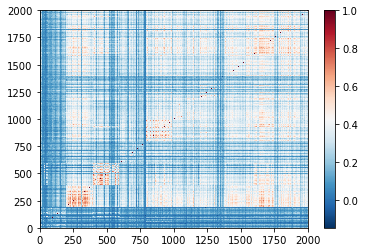

In [37]:
x = np.arange(2000)
y = np.arange(2000)
x, y = np.meshgrid(x, y)

intensity = corr_matrix.copy()[list_of_stocks.flatten(),:][:,list_of_stocks.flatten()]

plt.pcolormesh(x, y, intensity, cmap='RdBu_r')
plt.colorbar() 
plt.show()